## Load Dataset

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

In [2]:
iris = load_iris()
X = iris.data
y = iris.target_names[iris.target]

## AdaBoostClassifier

In [3]:
class SimpleMultiClassBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learners = []
        self.learner_weights = []
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        
        # Convert labels to [0, n_classes-1]
        y = self.label_encoder.fit_transform(y)
        n_classes = len(self.label_encoder.classes_)
        n_samples = X.shape[0]
        
        # Initialize weights uniformly
        sample_weight = np.full(n_samples, 1/n_samples)

        for _ in range(self.n_estimators):
            
            choosen_samples = np.random.choice(
                np.arange(0, n_samples), 
                size=n_samples,
                p=sample_weight
            )
            learner = clone(self.base_estimator)
            learner.fit(X[choosen_samples], y[choosen_samples], sample_weight=sample_weight)

            # Compute weighted error rate (misclassification rate)
            y_pred = learner.predict(X)
            correct_pred = np.array([1 if a == b else 0 for a, b in zip(y, y_pred)])
            miss_pred = 1 - correct_pred
            learner_error =  np.sum(miss_pred * sample_weight) / np.sum(sample_weight)
            
            # Compute learner weight using SAMME algorithm
            if learner_error >= 1 - (1 / n_classes):
                break  # Stop if the learner is no better than random guessing
            learner_weight = 0.5 * np.log((1.0 - learner_error)/1.0) + np.log(n_classes - 1)
            
            # Increase the weights of misclassified samples
            sample_weight = self._normalize(sample_weight * np.exp((miss_pred - correct_pred) * learner_weight))
            
            # Save the current learner
            self.learners.append(learner)
            self.learner_weights.append(learner_weight)

    def predict(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.label_encoder.classes_)
        
        # Collect predictions from each learner
        y_pred = np.array([learner.predict(X) for learner in self.learners])

        # Weighted vote for each sample's prediction across all learners
        votes = np.zeros((n_samples, n_classes))
        for i in range(n_samples):
            for vote, weight in zip(y_pred[:, i], self.learner_weights):
                votes[i][vote] += weight
        
        # Final prediction is the one with the highest weighted vote
        majority_vote = np.argmax(votes, axis=1)

        # Convert back to original class labels
        return self.label_encoder.inverse_transform(majority_vote)
    
    def _normalize(self, probs):
        return probs / np.sum(probs)
        

## Evaluation

In [4]:
def plt_confusion_matrix(y_true, y_pred, labels, title):
        
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(
            cm.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=True,
            xticklabels=labels, 
            yticklabels=labels, 
            cmap=plt.cm.Blues
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title + " - Confusion Matrix")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Accuracy: 1.0


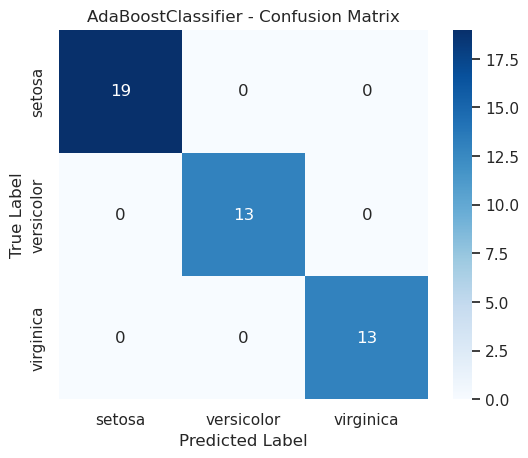

In [6]:
ada_Boost = SimpleMultiClassBoosting(n_estimators=3)
ada_Boost.fit(X_train, y_train)
y_pred = ada_Boost.predict(X_test)
 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
plt_confusion_matrix(y_test, y_pred, iris.target_names, "AdaBoostClassifier")
plt.savefig("../assets/Q4_cm.png")
plt.show()